In [4]:
import math
import matplotlib.pyplot as plt
import random
from typing import Callable, Tuple, Any
import numpy as np
import statistics

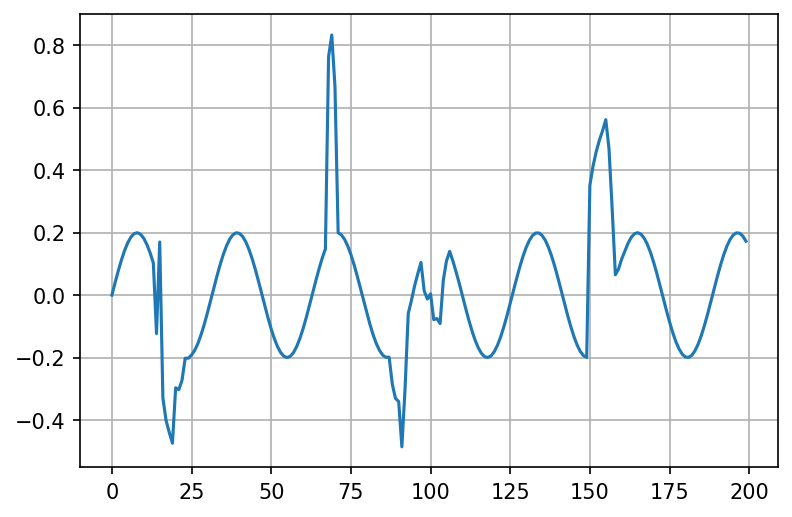

In [5]:
class SignalGenerator:
    data: list[float] = []
    x_list: list[int] = []
    file_name: str = "out.txt"

    def __init__(self, x_start: int = 0, x_end: int = 100) -> None:
        self._set_x_list(x_start, x_end)

    def _set_x_list(self, x_start: int, x_end: int):
        self.x_list = [x for x in range(x_start, x_end)]
        return self

    def _merge(self, data: list[float]):
        new_data = []
        for i in range(len(data)):
            current_data_item = 0
            try:
                current_data_item = self.data[i]
            except IndexError:
                pass
            new_data.append(data[i] + current_data_item)
        self.data = new_data

    def sin(self, a: float = 1, b: float = 1):
        self._merge([a * math.sin(x * b) for x in self.x_list])
        return self

    def cos(self, a: float = 1, b: float = 1):
        self._merge([a * math.cos(x * b) for x in self.x_list])
        return self

    def square_vawe(self, frequency: int = 10, height: int = 1):
        self._merge([height if (x % frequency) >= (frequency / 2) else 0 for x in self.x_list])
        return self

    def triangle_vawe(self, p: float = 50):
        self._merge([2 * math.fabs((x / p) - math.floor((x / p) + 0.5)) for x in self.x_list])
        return self

    def noise(self, y_min: float = -1, y_max: float = 1):
        self._merge([random.uniform(y_min, y_max) for _ in self.x_list])
        return self

    def linear(self, a: float = 1, b: float = 1):
        self._merge([a * x + b for x in self.x_list])
        return self

    def const(self, value = 0):
        self._merge([value for _ in self.x_list])
        return self

    def from_function(self, function: Callable[[int], float]):
        self._merge([function(x) for x in self.x_list])
        return self

    def with_peaks(self, 
        count: int = 1, 
        min_value: float = 0, 
        max_value: float = 1, 
        min_width: int = 1, 
        max_width: int = 10,
        direction: int = 1
    ):
        data = [0 for _ in self.x_list]
        for _ in range(count):
            x = random.randint(self.x_list[0], self.x_list[len(self.x_list) - 1])
            y = random.uniform(min_value, max_value)
            peak_y = y
            data[x] = y
            x_count = random.randint(min_width, max_width)
            last_y = min_value
            for i in reversed(range(math.floor(x_count / 2))):
                index = x - i - 1
                if index < 0:
                    continue
                y = random.uniform(last_y, peak_y)
                data[index] = y
                last_y = y
            last_y = peak_y
            for i in range(math.floor(x_count / 2)):
                index = x + i + 1
                if index > len(data) - 1:
                    continue
                y = random.uniform(last_y, min_value)
                data[index] = y
                last_y = y
        data = [y * direction for y in data]
        self._merge(data)
        return self

    def toFile(self):
        with open(self.file_name, 'w') as file:
            file.write(','.join(self.data))
        return self

    def draw(self):
        plt.figure(dpi=150)
        plt.plot(self.x_list, self.data)
        plt.grid()
        plt.show()
        return self

SignalGenerator(0, 200).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2).draw()

In [120]:
class Metric:
  def sum_differences(self, original: list[float], transformed: list[float], use_absolut_value: bool = True) -> float:
    differences = [original[i] - transformed[i] for i in range(len(original))]
    if use_absolut_value:
      differences = map(math.fabs, differences)
    return sum(differences)
  
  def arithmetic_average(self, original: list[float], transformed: list[float]) -> float:
    return self.sum_differences(original, transformed) / len(original)

  def standard_derivative(self, original: list[float], transformed: list[float]) -> float:
    n = len(original)
    return math.sqrt(sum([(original[i] - transformed[i])**2 for i in range(n)]) / n)
    
  def function_field(self, original: list[float], transformed: list[float], normalize: bool = True) -> float:
    original_field, transformed_field = np.trapz(original), np.trapz(transformed)
    return math.fabs(original_field - transformed_field) / (max(original_field, transformed_field) if normalize else 1)

  def min(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    if show_diff:
      return min(original) - min(transformed)
    return min(transformed)

  def max(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    if show_diff:
      return max(original) - max(transformed)
    return max(transformed)

  def min_max_diff(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    transformed_diff = abs(max(transformed) - min(transformed))
    if show_diff:
      original_diff = abs(max(original) - min(original))
      return abs(transformed_diff - original_diff)
    return transformed_diff

  def _value_crossing(self, data: list[float], border: float = 0, threshold: float = 0, direction: int = 0) -> float:
    if len(data) == 0:
      return 0

    counter = 0
    lastPosition = None
    position = None

    value = data[0]
    if value > border + threshold:
      lastPosition = 1
    elif value < border - threshold:
      lastPosition = -1
    else:
      lastPosition = 0
      counter = 1

    for value in data:
      if value > border + threshold:
        position = 1
      elif value < border - threshold:
        position = -1
      else:
        position = 0

      if direction == 0:
        if (position == 0 and lastPosition != 0) or (abs(position - lastPosition) == 2):
          counter += 1
      if direction > 0: # positive crossing
        if lastPosition < 0 and position != lastPosition:
          counter += 1
      if direction < 0: # negaive crossing
        if lastPosition > 0 and position != lastPosition:
          counter += 1

    return counter

  def value_crossing(
      self, 
      original: list[float], 
      transformed: list[float], 
      border: float = 0, 
      threshold: float = 0, 
      show_diff: bool = True,
      direction: int = 0
    ) -> float:
    original_cross_count = 0
    transformed_cross_count = self._value_crossing(transformed, border, threshold, direction)
    if show_diff:
      original_cross_count = self._value_crossing(original, border, threshold, direction)
    return transformed_cross_count - original_cross_count

  def positive_value_crossing(
      self, 
      original: list[float], 
      transformed: list[float], 
      border: float = 0, 
      threshold: float = 0, 
      show_diff: bool = True
    ) -> float:
    return self.value_crossing(original, transformed, border, threshold, show_diff, 1)

  def negative_value_crossing(
      self, 
      original: list[float], 
      transformed: list[float], 
      border: float = 0, 
      threshold: float = 0, 
      show_diff: bool = True
    ) -> float:
    return self.value_crossing(original, transformed, border, threshold, show_diff, -1)

  def _peak_detector(
      self, 
      y: list[float], 
      x: list[int] = [], 
      delta: float = 0.3
    ) -> tuple[tuple[list[float], list[float]], tuple[list[float], list[float]]]:
    maxtab = []
    mintab = [] 
    minimum = math.inf
    maximum = -math.inf
    minimum_x = None
    maximum_x = None
    look_for_max = True

    for i in range(len(y)):
        current = y[i]
        if current > maximum:
            maximum = current
            maximum_x = x[i]
        if current < minimum:
            minimum = current
            minimum_x = x[i]
        
        if look_for_max:
            if current < maximum - delta:
                maxtab.append((maximum_x, maximum))
                minimum = current
                minimum_x = x[i]
                look_for_max = False
        else:
            if current > minimum + delta:
                mintab.append((minimum_x, minimum))
                maximum = current
                maximum_x = x[i]
                look_for_max = True

    return [[i[0] for i in maxtab], [i[1] for i in maxtab]], [[i[0] for i in mintab], [i[1] for i in mintab]]

  def peak_count(self, original: list[float], transformed: list[float], delta: float = 0.3, show_diff: bool = True) -> float:
    original_peaks_count = 0
    peaks_positive, peaks_negative = self._peak_detector(transformed, [i for i in range(len(transformed))], delta)
    transformed_peaks_count = len(peaks_positive[0]) + len(peaks_negative[0])
    if show_diff:
      peaks_positive, peaks_negative = self._peak_detector(original, [i for i in range(len(original))], delta)
      original_peaks_count = len(peaks_positive[0]) + len(peaks_negative[0])
    return original_peaks_count - transformed_peaks_count

  def positive_peak_count(self, original: list[float], transformed: list[float], delta: float = 0.3, show_diff: bool = True) -> float:
    original_peaks_count = 0
    peaks_positive, _ = self._peak_detector(transformed, [i for i in range(len(transformed))], delta)
    transformed_peaks_count = len(peaks_positive[0])
    if show_diff:
      peaks_positive, _ = self._peak_detector(original, [i for i in range(len(original))], delta)
      original_peaks_count = len(peaks_positive[0])
    return original_peaks_count - transformed_peaks_count

  def negative_peak_count(self, original: list[float], transformed: list[float], delta: float = 0.3, show_diff: bool = True) -> float:
    original_peaks_count = 0
    _, peaks_negative = self._peak_detector(transformed, [i for i in range(len(transformed))], delta)
    transformed_peaks_count = len(peaks_negative[0])
    if show_diff:
      _, peaks_negative = self._peak_detector(original, [i for i in range(len(original))], delta)
      original_peaks_count = len(peaks_negative[0])
    return original_peaks_count - transformed_peaks_count

  def median(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    if show_diff:
      return statistics.median(original) - statistics.median(transformed)
    return statistics.median(transformed)
  
  def fft(self, transformed: list[float], show_plot: bool = False) -> Tuple[list[float], Any]:
    transformed_np_array = np.array(transformed)
    sp = np.fft.fft(transformed_np_array)
    freq = np.fft.fftfreq(transformed_np_array.shape[-1])
    if show_plot:
      plt.plot(freq, sp.real, freq, sp.imag)
    return sp, freq

  def _mean(self, data: list[float]) -> float:
    return sum(data) / len(data)

  def _covariance(self, x: list[float], y: list[float]) -> float:
    n = len(x)
    mean_x = self._mean(x)
    mean_y = self._mean(y)
    sum_distance = 0
    for i in range(n):
      sum_distance += (x[i] - mean_x) * (y[i] - mean_y)
    return sum_distance * 1/n

  def covariance(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    x_list = [i for i in range(len(transformed))]
    if show_diff:
      return self._covariance(x_list, original) - self._covariance(x_list, transformed)
    return self._covariance(x_list, transformed)

  def _corelation_pearson(self, x: list[float], y: list[float]) -> float:
    mean_x = self._mean(x)
    mean_y = self._mean(y)
    sum_distance = 0
    sum_distance_square_x = 0
    sum_distance_square_y = 0
    for i in range(len(x)):
      distance_x = (x[i] - mean_x)
      distance_y = (y[i] - mean_y)
      sum_distance += distance_x * distance_y
      sum_distance_square_x += distance_x ** 2
      sum_distance_square_y += distance_y ** 2
    return sum_distance / math.sqrt(sum_distance_square_x * sum_distance_square_y)

  def corelation_pearson(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    x_list = [i for i in range(len(transformed))]
    if show_diff:
      return self._corelation_pearson(x_list, original) - self._corelation_pearson(x_list, transformed)
    return self._corelation_pearson(x_list, transformed)

  def _corelation_spearman_on_injection(self, x: list[float], y: list[float]) -> float:
    data_len = len(x)
    n = data_len
    max_rang = data_len
    next_rang = max_rang
    x_rangs = [i + 1 for i in range(max_rang)]
    y_rangs = []
    y_sorted = sorted(y)
    print(y_sorted)
    i = 0
    while i < data_len:
      values_count = 1
      current_value = y[i]
      while i + values_count < data_len and y[i + values_count] == current_value:
        values_count += 1
      current_rang = sum(range(i, i + values_count)) / values_count
      for _ in range(values_count):
        y_rangs.append(current_rang)
      next_rang -= values_count
      i += values_count
    distance_sum = 0
    for i in range(data_len):
      distance_sum += (x_rangs[i] - y_rangs[i]) ** 2
    return 1 - ((6 * distance_sum) / (n * (n ** 2 - 1)))

  def corelation_spearman(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    x_list = [i for i in range(len(transformed))]
    if show_diff:
      return self._corelation_spearman_on_injection(x_list, original) - self._corelation_spearman_on_injection(x_list, transformed)
    return self._corelation_spearman_on_injection(x_list, transformed)

v = Metric().corelation_spearman([1,2,3,4,5,6,7,8,9], [1,1,1,-5,5,6,7,4,11], False)
print(v)

[-5, 1, 1, 1, 4, 5, 6, 7, 11]
0.9083333333333333


In [118]:
sum(range(4))

6

{'original_size': 100, 'compressed_size': 0, 'compression_rate': 1.0}


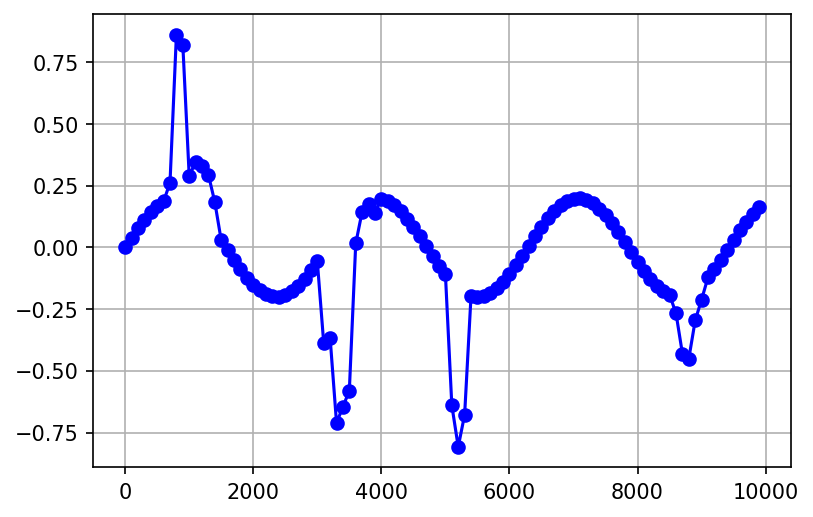

In [27]:
class Measurement:
  value: float
  timestamp: int

  def __init__(self, value: float, timestamp: float):
    self.value = value
    self.timestamp = timestamp

class DataCompressor:
  metric: Metric = Metric()
  original_data: list[Measurement] = []
  compressed_data: list[Measurement] = []

  # todo: create class
  compress_nths_conf = {
    'n': 3
  }

  # todo: create class
  compress_higher_deriveration_conf = {
    'deriveration': 0.05
  }

  # todo: create class
  compress_by_chunk_conf = {
    'chunk_size': 5
  }

  # todo: create class
  compress_min_max_conf = {
    'points_count': 30,
    'points_part': 0.5,
    'use_points_count': False
  }

  # todo: create class
  compress_with_density_conf = {

  }

  def __init__(self): # metrics config, compression config
    pass # todo
  
  def _fill_with_interpolate(self):
    pass # todo
  
  def valid(self):
    pass # todo

  def compress_nths(self):
    data_len = len(self.original_data)
    for i in range(0, data_len, self.compress_nths_conf['n']):
      self.compressed_data.append(self.original_data[i])
    if data_len % 3 != 0:
      self.compressed_data.append(self.original_data[data_len - 1])
    return self.compressed_data

  def compress_higher_deriveration(self):
    deriveration = self.compress_higher_deriveration_conf['deriveration']
    if len(self.original_data) == 0:
      return
    last_measurement_value = self.original_data[0].value
    for measurement in self.original_data:
      if abs(last_measurement_value - measurement.value) > deriveration:
        self.compressed_data.append(measurement)
        last_measurement_value = measurement.value

  def compress_by_chunk(self):
    chunk_size = self.compress_by_chunk_conf['chunk_size']
    if chunk_size < 1:
      return
    chunk: list[Measurement] = []
    for index, measurement in enumerate(self.original_data):
      if index != 0 and index % chunk_size == 0:
        value_average = chunk[0].value
        timestamp_average = chunk[0].timestamp
        for chunk_index in range(1, len(chunk)):
          value_average = (value_average + chunk[chunk_index].value) / 2
          timestamp_average = (timestamp_average + chunk[chunk_index].timestamp) / 2
        self.compressed_data.append(Measurement(value_average, round(timestamp_average)))
        chunk = []
      else:
        chunk.append(measurement)
    if len(chunk) != 0:
      for item in chunk:
        value_average = (value_average + item.value) / 2
        timestamp_average = (timestamp_average + item.timestamp) / 2
        self.compressed_data.append(Measurement(value_average, round(timestamp_average)))

  def compress_min_max(self):
    if len(self.original_data) == 0:
      return
    config = self.compress_min_max_conf
    if config['use_points_count']:
      points_count = config['points_count']
    else:
      points_count = round(len(self.original_data) * config['points_part'])
    if points_count < 1:
      return
    compressed_measurements_set = set()
    measurements = set(self.original_data)
    for _ in range(round(points_count / 2)):
      min_measurement = next(iter(measurements))
      max_measurement = next(iter(measurements))
      for measurement in measurements:
        if min_measurement.value > measurement.value:
          min_measurement = measurement
        if max_measurement.value < measurement.value:
          max_measurement = measurement
      measurements.remove(min_measurement)
      measurements.remove(max_measurement)
      compressed_measurements_set.add(min_measurement)
      compressed_measurements_set.add(max_measurement)
    self.compressed_data = sorted(compressed_measurements_set, key=lambda measurement: measurement.timestamp)
      
  def compress_with_density(self):
    pass
  
  def compress_perceptual_interesting_points(self):
    pass

  def compress(self):
    # todo: check metrics
    self.compress_most_interesting_points()

  def push(self, measurement: Measurement):
    self.original_data.append(measurement)
  
  def set_data(self, measurements: list[Measurement]):
    self.original_data = measurements

  def clean_data(self):
    self.original_data = []
    self.compressed_data = []

  def vizualize(self, show_compressed: bool = True, show_interpolation: bool = False):
    x_original = [measurement.timestamp for measurement in self.original_data]
    y_original = [measurement.value for measurement in self.original_data]
    plt.figure(dpi=150)
    if show_interpolation:
        plt.plot(x_original, y_original, 'b')
    plt.plot(x_original, y_original, 'bo')
    if show_compressed:
      x_compressed = [measurement.timestamp for measurement in self.compressed_data]
      y_compressed = [measurement.value for measurement in self.compressed_data]
      if show_interpolation:
        plt.plot(x_compressed, y_compressed, 'r')
      plt.plot(x_compressed, y_compressed, 'ro')
    plt.grid()
    plt.show()
    return self

  def get_data(self):
    return [measurement.value for measurement in self.compressed_data]

  def get_stats(self):
    return {
      'original_size': len(self.original_data),
      'compressed_size': len(self.compressed_data),
      'compression_rate': (len(self.original_data) - len(self.compressed_data)) / len(self.original_data)
    }

signal_generator = SignalGenerator(0, 100).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2)
# signal_generator.draw()
data_compressor = DataCompressor()

for index, measurement in enumerate(signal_generator.data):
  data_compressor.push(Measurement(measurement, index * 100))
# data_compressor.set_data([Measurement(i, i*100) for i in range(20)])
# data_compressor.compress()
# print(data_compressor.get_data())
print(data_compressor.get_stats())
data_compressor.vizualize(True, True)

In [25]:
import unittest

class TestStringMethods(unittest.TestCase):
  def test_upper(self):
    self.assertEqual('foo'.upper(), 'FOO')

  def test_isupper(self):
    self.assertTrue('FOO'.isupper())
    self.assertFalse('Foo'.isupper())

  def test_split(self):
    s = 'hello world'
    self.assertEqual(s.split(), ['hello', 'world'])
    # check that s.split fails when the separator is not a string
    with self.assertRaises(TypeError):
      s.split(2)

unittest.main(argv=[''], verbosity=2, exit=False)

test_isupper (__main__.TestStringMethods) ... ok
test_split (__main__.TestStringMethods) ... ok
test_upper (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK
